@Credits to 
https://nyu-cds.github.io/python-numba/05-cuda/

In [33]:
import numpy as np
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


## Kernel declaration

A kernel function is a GPU function that is meant to be called from CPU code. It has two fundamental characteristics:

*    kernels cannot explicitly return a value; all result data must be written to an array passed to the function (if computing a scalar, you will probably pass a one-element array);
*    kernels explicitly declare their thread hierarchy when called: i.e. the number of thread blocks and the number of threads per block (note that while a kernel is compiled once, it can be called multiple times with different block sizes or grid sizes).


In [21]:
@cuda.jit
def my_kernel(io_array):
    """
    Code for kernel.
    """
    # code here

## Kernel invovocation
There are two main steps:

*   Instantiate the kernel proper, by specifying a number of blocks per grid and a number of threads per block. The product of the two will give the total number of threads launched. Kernel instantiation is done by taking the compiled kernel function and indexing it with a tuple of integers.
*    Running the kernel, by passing it the input array (and any separate output arrays if necessary). By default, running a kernel is synchronous: the function returns when the kernel has finished executing and the data is synchronized back.


In [23]:
import numpy

# Create the data array - usually initialized some other way
data = numpy.ones(256)

# Set the number of threads in a block
threadsperblock = 32 

# Calculate the number of thread blocks in the grid
blockspergrid = (data.size + (threadsperblock - 1)) // threadsperblock

# Now start the kernel
my_kernel[blockspergrid, threadsperblock](data)

# Print the result
print(data)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

## Choosing the block size

The two-level thread hierarchy is important for the following reasons:

*    On the software side, the block size determines how many threads share a given area of shared memory.
*    On the hardware side, the block size must be large enough for full occupation of execution units; recommendations can be found in the CUDA C Programming Guide.

The block size you choose depends on a range of factors, including:

*    The size of the data array
*    The size of the shared memory per block (e.g. 64KB)
*    The maximum number of threads per block supported by the hardware (e.g. 512 or 1024)
*    The maximum number of threads per multiprocessor (MP) (e.g. 2048)
*    The maximum number of blocks per MP (e.g. 32)
*    The number of threads that can be executed concurrently (a “warp” i.e. 32)

The execution of threads in a warp has a big effect on the computational throughput. If all threads in a warp are executing the same instruction then they can all be executed in parallel. But if one or more threads is executing a different instruction, the warp has to be split into groups of threads, and these groups execute serially.

Rules of thumb for threads per block:

*    Should be a round multiple of the warp size (32)
*    A good place to start is 128-512 but benchmarking is required to determine the optimal value.

Each streaming multiprocessor (SP) on the GPU must have enough active warps to achieve maximum throughput. In other words, the blocksize is usually selected to maximize the “occupancy”. See the CUDA (http://developer.download.nvidia.com/compute/cuda/CUDA_Occupancy_calculator.xls)
Occupancy Calculator spreadsheet for more details.

## Thread positioning

When running a kernel, the kernel function’s code is executed by every thread once. It therefore has to know which thread it is in, in order to know which array element(s) it is responsible for. More complex algorithms may define more complex responsibilities, but the underlying principle is the same.

To help deal with multi-dimensional arrays, CUDA allows you to specify multi-dimensional blocks and grids. In the example above, you could make blockspergrid and threadsperblock tuples of one, two or three integers. Compared to 1-dimensional declarations of equivalent sizes, this doesn’t change anything to the efficiency or behaviour of generated code, but can help you write your algorithms in a more natural way.

One way is for the thread to determines its position in the grid and block and manually compute the corresponding array position:

In [25]:
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < io_array.size:  # Check array boundaries
        io_array[pos] *= 2 # do the computation

In [28]:
# Now start the kernel
my_kernel[blockspergrid, threadsperblock](data)

# Print the result
print(data)

[ 8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8

Note: Unless you are sure the block size and grid size is a divisor of your array size, you must check boundaries as shown above.

The following special objects are provided by the CUDA backend for the sole purpose of knowing the geometry of the thread hierarchy and the position of the current thread within that geometry:

*    numba.cuda.threadIdx - The thread indices in the current thread block. For 1-dimensional blocks, the index (given by the x attribute) is an integer spanning the range from 0 to numba.cuda.blockDim - 1. A similar rule exists for each dimension when more than one dimension is used.
*    numba.cuda.blockDim - The shape of the block of threads, as declared when instantiating the kernel. This value is the same for all threads in a given kernel, even if they belong to different blocks (i.e. each block is “full”).
*    numba.cuda.blockIdx - The block indices in the grid of threads launched a kernel. For a 1-dimensional grid, the index (given by the x attribute) is an integer spanning the range from 0 to numba.cuda.gridDim - 1. A similar rule exists for each dimension when more than one dimension is used.
*    numba.cuda.gridDim - The shape of the grid of blocks, i.e. the total number of blocks launched by this kernel invocation, as declared when instantiating the kernel.

These objects can be 1-, 2- or 3-dimensional, depending on how the kernel was invoked. To access the value at each dimension, use the x, y and z attributes of these objects, respectively.

## Absolute positions

Simple algorithms will tend to always use thread indices in the same way as shown in the example above. Numba provides additional facilities to automate such calculations:

*    numba.cuda.grid(ndim) - Return the absolute position of the current thread in the entire grid of blocks. ndim should correspond to the number of dimensions declared when instantiating the kernel. If ndim is 1, a single integer is returned. If ndim is 2 or 3, a tuple of the given number of integers is returned.
*    numba.cuda.gridsize(ndim) - Return the absolute size (or shape) in threads of the entire grid of blocks. ndim has the same meaning as in grid() above.

Using these functions, the our example can become:

In [29]:
@cuda.jit
def my_kernel2(io_array):
    pos = cuda.grid(1)
    if pos < io_array.size:
        io_array[pos] *= 2 # do the computation

## Memory management

Numba has been automatically transferring the NumPy arrays to the device when you invoke the kernel. However, it can only do so conservatively by always transferring the device memory back to the host when a kernel finishes. To avoid the unnecessary transfer for read-only arrays, it is possible to manually control the transfer.

In [31]:
# Allocates empty device ndarray
shape = (int(10e6))
device_array = cuda.device_array( shape )

In [33]:
# Allocate and transfer a NumPy ndarray to the device.
array = np.ones(int(10e6))
device_array = cuda.to_device( array )

## Matrix Multiplication

The following code sample is a straightforward implementation of matrix multiplication for matrices where each thread reads one row of A and one column of B and computes the corresponding element of C. For input arrays where A.shape == (m, n) and B.shape == (n, p) then the result shape will be C.shape = (m, p).

In [39]:
from __future__ import division
from numba import cuda
import numpy
import math

# CUDA kernel
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp
        
# Host code

# Initialize the data arrays
A = numpy.full((24, 12), 3, numpy.float) # matrix containing all 3's
B = numpy.full((12, 22), 4, numpy.float) # matrix containing all 4's

# Copy the arrays to the device
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(B)

# Allocate memory on the device for the result
C_global_mem = cuda.device_array((24, 22))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Start the kernel 
matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)

# Copy the result back to the host
C = C_global_mem.copy_to_host()

print(C)

[[ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.  144.
   144.  144.  144.  144.  144.  144.  144.  144.  144.  144.]
 [ 144.  144.  144.  144.  144.  144.  14

A problem with this code is that each thread is reading from the global memory containing the copies of A and B. In fact, the global memory is read B.shape[1] times and A.shape[0] times. Since Global memory is fairly slow, this results in an inefficient use of GPU.

## Shared memory and thread synchronization

A limited amount of shared memory can be allocated on the device to speed up access to data, when necessary. That memory will be shared (i.e. both readable and writable) amongst all threads belonging to a given block and has faster access times than regular device memory. It also allows threads to cooperate on a given solution. You can think of it as a manually-managed data cache.

The function to create a shared memory array is:

`shared_array = cuda.shared.array(shape,type)
`
* shape:
is either an integer or a tuple of integers representing the array’s dimensions.
* type:
is a Numba type of the elements needing to be stored in the array.

The memory is allocated once for the duration of the kernel, unlike traditional dynamic memory management.
Because the shared memory is a limited resource, it is often necessary to preload a small block at a time from the input arrays. All the threads then need to wait until everyone has finished preloading before doing the computation on the shared memory.

Synchronization is then required again after the computation to ensure all threads have finished with the data in shared memory before overwriting it in the next loop iteration.

The function to synchronized threads is:

`
cuda.syncthreads()
`

This function will synchronize all threads in the same thread block. This function implements the same pattern as barriers in traditional multi-threaded programming and the MPI.Barrier() function. The program will wait until all threads in the block call the function, at which point it returns control to all its callers.

## Improved matrix multiplication

The following example shows how shared memory can be used when performing matrix multiplication.

In this example, each thread block is responsible for computing a square sub-matrix of C and each thread for computing an element of the sub-matrix. The sub-matrix is equal to the product of a square sub-matrix of A (sA) and a square sub-matrix of B (sB). In order to fit into the device resources, the two input matrices are divided into as many square sub-matrices of dimension TPB as necessary, and the result computed as the sum of the products of these square sub-matrices.

Each product is performed by first loading sA and sB from global memory to shared memory, with one thread loading each element of each sub-matrix. Once sA and sB have been loaded, each thread accumulates the result into a register (tmp). Once all the products have been calculated, the results are written to the matrix C in global memory.

By blocking the computation this way, we can reduce the number of global memory accesses since A is now only read B.shape[1] / TPB times and B is read A.shape[0] / TPB times.

In [2]:
from __future__ import division
from numba import cuda, float32
import numpy
import math

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 2

@cuda.jit
def fast_matmul(A, B, C):
    """
    Perform matrix multiplication of C = A * B
    Each thread computes one element of the result matrix C
    """

    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)
    
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(int(A.shape[1] / TPB)):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

# The data array
A = numpy.full((TPB*2, TPB*100000), 3, numpy.float) # [4 x 16] matrix containing all 3's
B = numpy.full((TPB*100000, TPB*2), 4, numpy.float) # [16 x 4] matrix containing all 4's

#print("A: {}\n".format(A))
#print("B: {}\n".format(B))

A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(B)
C_global_mem = cuda.device_array((TPB*2, TPB*2)) # [4 x 4] matrix result

# Configure the blocks
threadsperblock = (TPB, TPB)
blockspergrid_x = int(np.ceil(A.shape[0] / threadsperblock[1]))
blockspergrid_y = int(np.ceil(B.shape[1] / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)
print('blockspergrid{}'.format(blockspergrid))
print('threadsperblock{}'.format(threadsperblock))



blockspergrid(2, 2)
threadsperblock(2, 2)


In [3]:
%time
# Start the kernel 
fast_matmul[blockspergrid, threadsperblock](A_global_mem, B_global_mem, C_global_mem)
res = C_global_mem.copy_to_host()

print(res)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
[[ 2400000.  2400000.  2400000.  2400000.]
 [ 2400000.  2400000.  2400000.  2400000.]
 [ 2400000.  2400000.  2400000.  2400000.]
 [ 2400000.  2400000.  2400000.  2400000.]]


In [5]:
%time
np.matmul(A,B)
# whatever numpy is doing is awsome...

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.96 µs


array([[ 2400000.,  2400000.,  2400000.,  2400000.],
       [ 2400000.,  2400000.,  2400000.,  2400000.],
       [ 2400000.,  2400000.,  2400000.,  2400000.],
       [ 2400000.,  2400000.,  2400000.,  2400000.]])

## Voronoi with Jump Flood


In [161]:

Seeds_Position = [(50,50), (100,250), (300,200), (169,169), (10,40)]

Seed_number = len(Seeds_Position)
A = np.zeros((320,320)) -1
for i in range(len(Seeds_Position)):
    A[Seeds_Position[i]] = i

offsets = [ (-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1),(0,0) ]
offsets_number = len(offsets)

@cuda.jit
def Voronoi(A, B, Seeds_Position, offsets, k):
    cellx, celly = cuda.grid(2)
    
    soffsets= cuda.shared.array(shape=(offsets_number, 2), dtype=float32)
    sSeeds_Position = cuda.shared.array(shape=(Seed_number, 2), dtype=float32)
    
    # first thread of each block copies Seeds_Position and offsets to shared memory
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    if tx == 0 and ty == 0:
        cuda.syncthreads()
        for i in range(offsets_number):
            soffsets[i,0] = offsets[i,0]
            soffsets[i,1] = offsets[i,1]
        for i in range(Seed_number):
            sSeeds_Position[i,0] = Seeds_Position[i,0]
            sSeeds_Position[i,1] = Seeds_Position[i,1]
        cuda.syncthreads()
        
    seed = A[cellx,celly]
    if (seed < 0):
        return
    
    for i in range(len(offsets)):
        nextCellx = int(cellx + k*soffsets[i][0])
        nextCelly = int(celly + k*soffsets[i][1])
        
        if nextCellx>0 and nextCellx<A.shape[0] and nextCelly>0 and nextCelly<A.shape[1]:
            
            # Critical Session
            cuda.syncthreads()

            nextSeed = B[nextCellx,nextCelly]
            if nextSeed < 0:
                B[nextCellx,nextCelly] = seed
            else:
                # Read shared memory
                seedx,seedy = sSeeds_Position[int(seed)]
                nextSeedx,nextSeedy = sSeeds_Position[int(nextSeed)]
                
                # compute distance from seed and nextSeed
                dist_seed = (nextCellx - seedx)**2 + (nextCelly - seedy)**2
                dist_nextSeed = (nextCellx - nextSeedx)**2 + (nextCelly - nextSeedy)**2
                if dist_seed < dist_nextSeed:
                    B[nextCellx,nextCelly] = seed
                    
            cuda.syncthreads()


                

In [173]:

n,m = A.shape       
A_global_mem = cuda.to_device(A)
B_global_mem = cuda.to_device(A)
Seeds_Position_global_mem = cuda.to_device(np.array(Seeds_Position,dtype=np.int32))
offsets_global_mem = cuda.to_device(np.array(offsets,dtype=np.int32))


TPB = 32
threadsperblock = (TPB,TPB)
blockspergrid = ((n+TPB-1)//TPB, (m+TPB-1)//TPB)
print(A.shape)
print(blockspergrid)
print(threadsperblock)

q = 2
k = n
while(k>0):
    k = n//(2**q)
    q += 1
    if q%2 == 0:
        src,dst = A_global_mem,B_global_mem
    else:
        src,dst = B_global_mem,A_global_mem
    Voronoi[blockspergrid, threadsperblock](src, dst,
                                            Seeds_Position_global_mem, 
                                            offsets_global_mem,
                                            k)

res = dst.copy_to_host()

(320, 320)
(10, 10)
(32, 32)


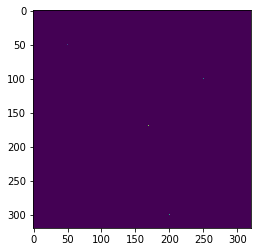

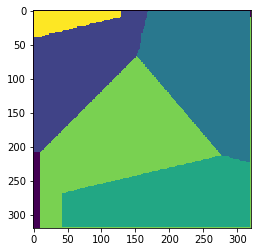

In [174]:
import matplotlib.pyplot as plt

plt.imshow(A)
plt.show()

plt.imshow(res)
plt.show()